# TELCO CUSTOMER CHURN

Objetivo: Detección de clientes con propensión a fuga en empresa de telecomunicaciones


In [3]:
#!pip install scorecardpy

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scorecardpy as sc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import xgboost as xgb

In [43]:
#1.- Lectura de datos históricos y data nueva para validación posterior
db = pd.read_csv('data/TelcoCustomerChurn.csv', na_values= ' ') #data histórica
db.info()
db.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   

      PaymentMethod MonthlyCharges  TotalCharges  Churn  
0  Electronic check          29.85         29.85     No  
1      Mailed check          56.95       1889.50     No  
2      Mailed check          53.85        108.15    Yes  

[3 rows x 21 columns]

In [44]:
#2.- Limpieza y Preparación de los datos
#¿Hay Datos nulos?
db.isnull().sum()*100/db.shape[0]
# En la columna 'TotalCharges' tenemos 0.16% de nulos. Decidimos eliminar los nulos dada su mínima presencia frente al total.
db_ = db.dropna()

In [45]:
# ¿Cómo está distribuida la variable objetivo?
# La columna 'Churn' representa la clasificación del cliente como retirado (SI =1) o (No = 0).
# Lo convertimos a valor binario en la columna 'target0. Esta es la columna objetivo para el modelo de clasificación  
db_['target'] = np.where(db_['Churn']== 'No',0,1)
#Composición de la fuga:
db_['target'].value_counts(normalize= True)
# Los clientes que dejan el servicio (fuga) representan el 27% del total
# Se observan clases desbalanceadas que pueden ser tratadas con técnicas de oversampling, undersampling, smote en una siguiente versión

/var/folders/kl/lhxmsbjj2s99j4m_l81z2dpr0000gn/T/ipykernel_93547/2157756864.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_['target'] = np.where(db_['Churn']== 'No',0,1)


0    0.734215
1    0.265785
Name: target, dtype: float64

In [46]:
#Retirar columnas : customerID 
db_ = db_.drop(columns= ['customerID','Churn'],axis = 1)


In [47]:
# ¿Qué tipo de variables tenemos?
var_num = ['tenure','MonthlyCharges','TotalCharges']
var_cat = list (set(db_.columns) - set(var_num))
var_cat.remove('target')
for c in var_cat:
    print (c)
    print (db_ [c].value_counts())

gender
Male      3549
Female    3483
Name: gender, dtype: int64
Partner
No     3639
Yes    3393
Name: Partner, dtype: int64
PhoneService
Yes    6352
No      680
Name: PhoneService, dtype: int64
PaperlessBilling
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64
TechSupport
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64
SeniorCitizen
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
OnlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64
Contract
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64
PaymentMethod
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64
StreamingTV
No                     2809
Yes                    2703
No internet service    1520
Name: Streaming

In [48]:
db_['avgCharges'] = db_['TotalCharges'] / db_ ['tenure']
corr_df = db_[['tenure','MonthlyCharges','TotalCharges','avgCharges','target']].corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')
#Existe un alto coeficiente de correlación entre 'tenure' y 'TotalCharges' , esto se debe a qué el monto total pagado
#por el cliente se irá incrementando cuando tenga más meses de antiguedad en la compañía


In [49]:
db_.drop( columns =['avgCharges'])

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7038               Yes             DSL            Yes           No   
7039               Yes     Fiber optic             No          Yes   
7040  No phone service             DSL            Yes           No   
7041               Yes     Fiber optic             No           No   
7042                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
2                 Yes               Mailed check           53.85   
3                  No  Bank transfer (automatic)           42.30   
4                 Yes           Electronic check           70.70   
...               ...                        ...             ...   
7038              Yes               Mailed check           84.80   
7039              Yes    Credit card (automatic)          103.20   
7040              Yes           Electronic check           29.60   
7041              Yes               Mailed check           74.40   
7042              Yes  Bank transfer (automatic)          105.65   

      TotalCharges  target  
0            29.85       0  
1          1889.50       0  
2           108.15       1  
3          1840.75       0  
4           151.65       1  
...            ...     ...  
7038       1990.50       0  
7039       7362.90       0  
7040        346.45       0  
7041        306.60       1  
7042       6844.50       0  

[7032 rows x 20 columns]

In [50]:
# Probamos la libreria Scorecardpy para filtrar variables considerando factores como: information value, missing rate, identical value rate.
dt_s= sc.var_filter(db_, y="target")
dt_s.head(3)

[INFO] filtering variables ...


Partner PaperlessBilling TechSupport  avgCharges  TotalCharges  \
0     Yes              Yes          No   29.850000         29.85   
1      No               No          No   55.573529       1889.50   
2      No              Yes          No   54.075000        108.15   

   SeniorCitizen OnlineBackup        Contract     PaymentMethod  tenure  \
0              0          Yes  Month-to-month  Electronic check       1   
1              0           No        One year      Mailed check      34   
2              0          Yes  Month-to-month      Mailed check       2   

  StreamingTV Dependents OnlineSecurity InternetService  MonthlyCharges  \
0          No         No             No             DSL           29.85   
1          No         No            Yes             DSL           56.95   
2          No         No            Yes             DSL           53.85   

  DeviceProtection StreamingMovies  target  
0               No              No       0  
1              Yes              No       0  
2               No              No       1

In [51]:
#Indicio de variables con menor valor predictivo
set (db_.columns) - set(dt_s.columns)

{'MultipleLines', 'PhoneService', 'gender'}

In [52]:
bins = sc.woebin(dt_s, y="target")

[INFO] creating woe binning ...


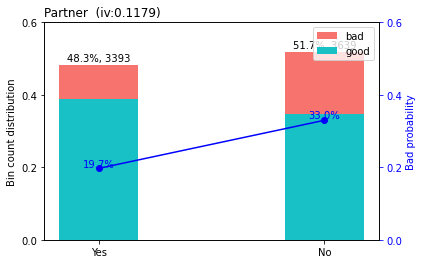

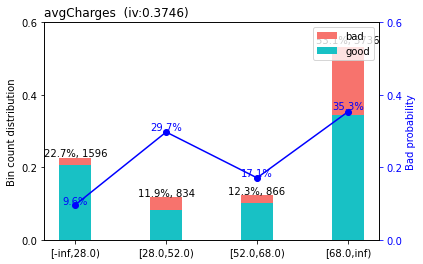

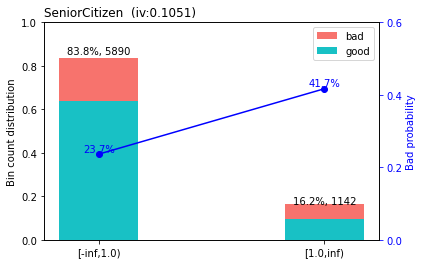

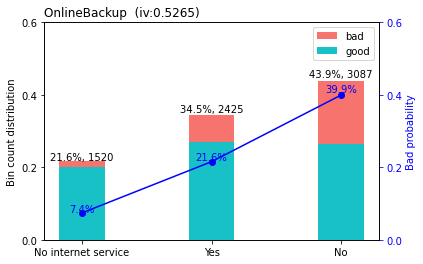

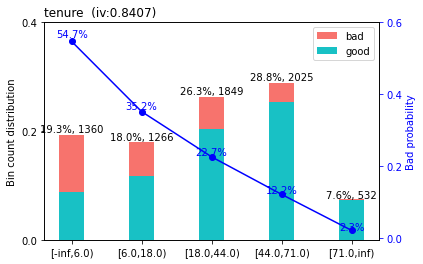

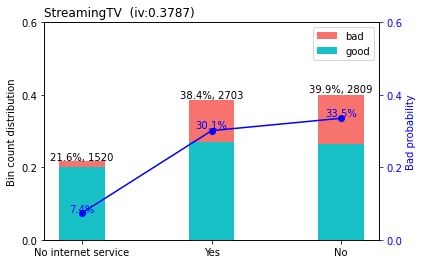

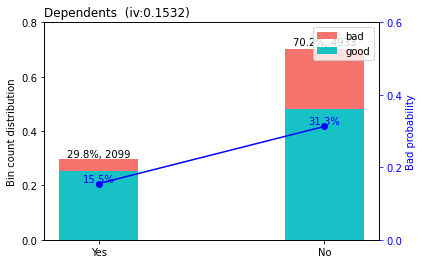

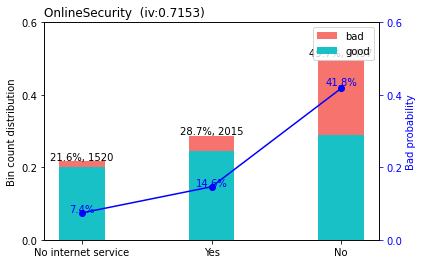

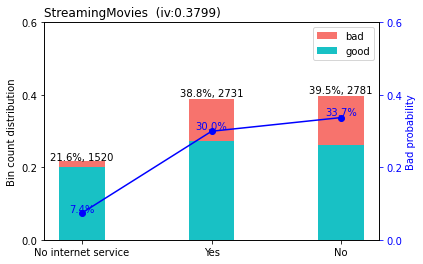

In [53]:
sc.woebin_plot(bins);


Hallazgos:
- El 39% de los clientes que no cuentan con protección en su dispositivo se han retirado frente al 22% de retirados para el grupo de los que si cuentan con protección en su dispositivo.
- Los clientes que tienen servicio de internet por medio de fibra óptica son los que en mayor porcentaje se han retirado de la compañía (44%). Se puede explorar si se debe a calidad del servicio por fibra óptica, o la competencia brinda mejores condiciones o su permanencia estaba asociada a alguna campala temporal.
- Los clientes con un cargo mensual entre 68 y 106 representan cerca al 50% de los clientes de la muestra, y es en ese grupo donde se tiene la mayor incidencia de retirados (37.6%). Se puede evaluar una mejora de condiciones de los planes que comprenden ese grupo.
- Los clientes que pagan por cheque electrónico han tenido mayor incidencia a retirarse (33.6%). Se puede promover el uso de los otros medios y revisar si el proceso de los pagos por cheque electrónico significa mayor complejidad, esfuerzo u otra acción que represente un punto de dolor para el cliente. 
- El grupo de los que no tienen seguridad en su línea (50% del total de la muestra) son los que han tenido un myor porcentaje de retiros (42%)
- Los clientes que no tienen respaldo en linea históricamente son más propensos a retirarse (40%).
- Históricamente se observa que cuánto más antiguo es un cliente, menor propensión tiene a retirarse. En el primer grupo de clientes con menos de 6 meses se tiene que más del 50% de los clientes se retiran, esto puede deberse a que se mantienen mientras dure una promoción inicial de descuentos ( se puede cruzar con data de campañas) o a experiencias negativas con el servicio ( cruzar con data de calidad o de interacción con el cliente)
- Los clientes con facturación electrónica tienen un ratio de retiro equivalente al doble de aquellos que no lo tienen. Se puede revisar si el servicio de facturación electrónica está siendo efectivo, llegan las facturas correctamente y de forma oportuna?
- Los clientes con un contrato mes a mes historicamente tienen mayor propensión al retiro (42%) 
- Los clientes que tienen soporte técnico tienen una tasa de retiro 3 veces menor que aquellos que no tienen soporte técnico.

In [54]:
# Convirtiendo variables categóricas a numéricas
var_cat2 = var_cat.copy()
var_cat2.remove('SeniorCitizen')# está en formato numérico
print (db_[var_cat2].describe())
prefix_cat = ['gen','DevProt','IntSer','PayMet','StrTV','MulLin','OnlSec','OnlBac','PhoSer','StrMov',
          'Par','PapLesBil','Con','Dep','TecSup']
data_encoded = pd.get_dummies(db_[var_cat2], drop_first = True,prefix = prefix_cat)

# Escalando las variables numéricas
scaler = StandardScaler()
scaler.fit(db_[var_num])
data_scaled = pd.DataFrame (scaler.transform(db_[var_num]), columns= ['tenure_sc', 'MonthlyCharges_sc', 'TotalCharges_sc'],
                           index = db_.index)


       gender Partner PhoneService PaperlessBilling TechSupport OnlineBackup  \
count    7032    7032         7032             7032        7032         7032   
unique      2       2            2                2           3            3   
top      Male      No          Yes              Yes          No           No   
freq     3549    3639         6352             4168        3472         3087   

              Contract     PaymentMethod StreamingTV Dependents  \
count             7032              7032        7032       7032   
unique               3                 4           3          2   
top     Month-to-month  Electronic check          No         No   
freq              3875              2365        2809       4933   

       OnlineSecurity InternetService MultipleLines DeviceProtection  \
count            7032            7032          7032             7032   
unique              3               3             3                3   
top                No     Fiber optic          

In [55]:
data_trf= data_scaled.join(data_encoded)
data_trf['SeniorCitizen']= db_['SeniorCitizen']

In [56]:
#3. Modelado
# Se cuentan con variados algoritmos de Machine Learning que pueden usarse para obtener la clasificación de propensión a fuga
# Probaremos con el modelo Random Forest por su robustez para resolver este tipo de problemas y aplicaremos  
# tunning del modelo para lograr los mejores resultados.

X_train, X_test, y_train, y_test = model_selection.train_test_split(data_trf, db_['target'], test_size = 0.3,random_state = 20 )

model = ensemble.RandomForestClassifier(n_estimators=100, max_depth= 8, criterion= 'entropy', n_jobs= -1)
model.fit(X= X_train, y=y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=-1)

In [57]:
# Evaluación en train (referencia)
y_pred0 = model.predict (X= X_train)

print ('Accuracy', metrics.accuracy_score(y_train, y_pred0.ravel()))
print ('Precision', metrics.precision_score(y_train, y_pred0.ravel()))
print ('Recall', metrics.recall_score(y_train, y_pred0.ravel()))
print ('F1', metrics.f1_score(y_train, y_pred0.ravel()))

Accuracy 0.8271028037383178
Precision 0.750816104461371
Recall 0.5259146341463414
F1 0.6185567010309277


In [58]:
#4. Evaluación
# Probamos en data no usada en el entrenamiento
y_pred_prob = model.predict_proba (X= X_test)
y_pred = model.predict (X= X_test)

print ('Accuracy', metrics.accuracy_score(y_test, y_pred.ravel()))
print ('Precision', metrics.precision_score(y_test, y_pred.ravel()))
print ('Recall', metrics.recall_score(y_test, y_pred.ravel()))
print ('F1', metrics.f1_score(y_test, y_pred.ravel()))

Accuracy 0.8014218009478673
Precision 0.6666666666666666
Recall 0.4955116696588869
F1 0.568486096807415


/Users/ebalbuena/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


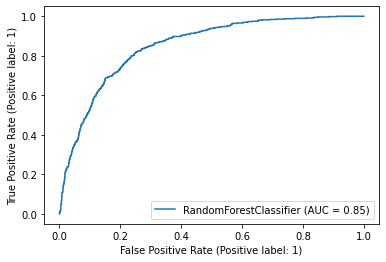

In [59]:
metrics.plot_roc_curve (estimator= model , X= X_test, y= y_test)

Observamos resultados aceptables para el modelo con un accuracy del 80% en el test y precision de 70%. Se observan valores menores para las métricas en el test que en el train, por lo que aplicaremos cross validation para evitar el sobreajuste y búsqueda de los hiperparámetros óptimos del modelo mediante el uso de una grilla. 

In [60]:
params = { 
    "max_depth" :list (range (5,100,3)),
    "criterion" : ['gini', 'entropy'],
    "max_features" : ['auto','sqrt'],
    "n_estimators" : list (range (50,200,10))
    }
model = ensemble.RandomForestClassifier (n_jobs = 4)
n_iters = 20

random_search = model_selection.RandomizedSearchCV(estimator= model , 
                                              param_distributions = params,
                                              n_iter= n_iters, scoring = 'f1', cv= 5, verbose= 1, n_jobs= 2,
                                              random_state =10)
random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4), n_iter=20,
                   n_jobs=2,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 8, 11, 14, 17, 20, 23,
                                                      26, 29, 32, 35, 38, 41,
                                                      44, 47, 50, 53, 56, 59,
                                                      62, 65, 68, 71, 74, 77,
                                                      80, 83, 86, 89, 92, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 60, 70, 80, 90,
                                                         100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                                         180, 190]},
                   random_state=10, scoring='f1',

{'n_estimators': 110, 'max_features': 'auto', 'max_depth': 11, 'criterion': 'entropy'}
Accuracy 0.8037914691943128
Precision 0.6585365853658537
Recall 0.533213644524237
F1 0.5892857142857142


/Users/ebalbuena/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


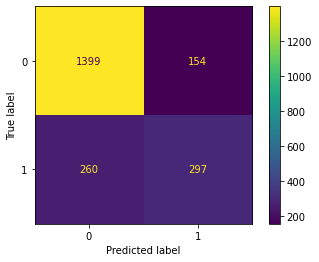

In [61]:
best_model = random_search.best_estimator_
best_parameters = random_search.best_params_
print (best_parameters)

y_pred_prob = best_model.predict_proba (X= X_test)
y_pred = best_model.predict (X= X_test)

print ('Accuracy', metrics.accuracy_score(y_test, y_pred.ravel()))
print ('Precision', metrics.precision_score(y_test, y_pred.ravel()))
print ('Recall', metrics.recall_score(y_test, y_pred.ravel()))
print ('F1', metrics.f1_score(y_test, y_pred.ravel()))
metrics.plot_confusion_matrix (estimator = best_model , X= X_test, y_true= y_test)

Obtenemos un modelo con un F1 score de 58% que es una medida que representa el balance entre los casos de detección de retiro y no-retiro correctamente, y precision de 65%  => Precision = (retiros predichos correctamente / (retiros predichos correctamente + retiros falsamente predichos)), lo cuál significa que el 65% de los casos predichos  como fuga son correctos.

IMPORTANCIA DE VARIABLES

<AxesSubplot:ylabel='feature'>

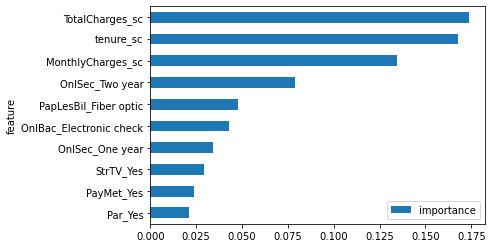

In [62]:
importance = pd.DataFrame ({"feature": X_train.columns, "importance": best_model.feature_importances_}).sort_values("importance")
importance.tail(10).plot.barh(x="feature", y= "importance")

Observamos que las variables que tienen mayor aporte al modelo son: TotalCharges, Tenure, MonthlyCharges, Contract e InternetService
Como escenarios a probar/evaluar en el  queda: la selección de variables (excluyendo TotalCharges que tiene una alta correlación con MonthlyCharges), reducción de variables con muy bajo valor de importancia para el modelo (ejm: SeniorCitizen)
Prueba de otros modelos : XGB classifier, LGBM 
Prueba de otros modelos de explicabilidad: SHAP

In [63]:
# grabado de modelo y scaler
import pickle as pkl

with open("model/scaler.pickle", "wb") as f:
    pkl.dump(scaler, f)
    
with open("model/model_rf.pickle", "wb") as f:
    pkl.dump(best_model, f)

# VALIDACIÓN


In [64]:
# Cargamos el modelo previamente entrenado y la escala usada para transformar los datos

with open("model/scaler.pickle", "rb") as f:
    scaler = pkl.load(f)
print(scaler)

with open("model/model_rf.pickle", "rb") as f:
    model_rf = pkl.load(f)
print(model_rf)

StandardScaler()
RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=110,
                       n_jobs=4)


In [69]:
#Aplicamos la transformación a la data nueva
db_new = pd.read_csv('data/TelcoCustomerChurn_New.csv', sep =';',na_values= ' ') #data nueva
data = db_new.drop(columns= ['customerID'],axis = 1).copy()

# Transformación para que ingrese al modelo
prefix_cat = ['gen','DevProt','IntSer','PayMet','StrTV','MulLin','OnlSec','OnlBac','PhoSer','StrMov',
          'Par','PapLesBil','Con','Dep','TecSup']
data_encoded = pd.get_dummies(data[var_cat2], drop_first = True,prefix = prefix_cat)

# Escalando las variables numéricas
data_scaled = pd.DataFrame (scaler.transform(data[var_num]), columns= ['tenure_sc', 'MonthlyCharges_sc', 'TotalCharges_sc'],
                           index = data.index)

new_trf= data_scaled.join(data_encoded)
new_trf['SeniorCitizen']= data['SeniorCitizen']

In [85]:
# Predicción con la data nueva
y_pred_new = model_rf.predict (X= new_trf)
y_pred_new

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [87]:
len (y_pred_new [y_pred_new == 1])/ y_pred_new.shape[0]

0.3157894736842105

In [90]:
(y_pred_new [y_pred_new == 1])

array([1, 1, 1, 1, 1, 1])

6.- Validar el modelo o prototipo construido con una parte de la información, adicional se le pide plantear estrategias de implementación o responder a la pregunta, ¿Cuánto es la cantidad de clientes a gestionar para por lo menos detectar el 40% de los fugados? 

Recall = (retiros predichos correctamente / total de retiros reales),
Lo cuál significa que el modelo puede reconocer el 53% de los clientes que se retirarán.

Considerando los datos nuevos (19 casos) , obtenemos 6 casos propensos a fuga (31.5%). Realizando la gestión de estos 6 casos podemos detectar el 53 % de clientes fugados y generar acciones para evitar la perdida.


Si la base es lograr detectar 40% de los fugados, se puede flexibilizar el límite de probabilidad de fuga.


In [93]:
# Predicción de probabilidades de fuga. Para el caso se está considerando como fuga predicha a las probabilidades 
# mayores a 50% 
y_pred_new_p = model_rf.predict_proba (X= new_trf)
y_pred_new_p 

array([[0.99426749, 0.00573251],
       [0.8711175 , 0.1288825 ],
       [0.47370268, 0.52629732],
       [0.99612562, 0.00387438],
       [0.42810361, 0.57189639],
       [0.44566425, 0.55433575],
       [0.93835391, 0.06164609],
       [0.76187293, 0.23812707],
       [0.63863183, 0.36136817],
       [0.35284599, 0.64715401],
       [0.89900652, 0.10099348],
       [0.50044206, 0.49955794],
       [0.50413722, 0.49586278],
       [0.99438302, 0.00561698],
       [0.48161296, 0.51838704],
       [0.46356843, 0.53643157],
       [0.605607  , 0.394393  ],
       [0.56501737, 0.43498263],
       [0.84415998, 0.15584002]])

Implementación:
- Se pueden generar grupos de clientes por niveles de probabilidad de fuga, haciendo foco en los que tienen más del 50% y plantear acciones diferenciadas para cada grupo considerando el cruce con las variables principales
- Determinar grupos de control para validar la eficacia de las acciones para cada grupo
- Realizar las mediciones del ratio de fuga y su impacto en las métricas de negocio asociado ( cobertura o margen) que se desee priorizar.
- Realizar el flujo productivo de la solución integrando el flujo operativo y el monitoreo del modelo, indicadores y acciones aplicadas. 